## VGAN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.utils import save_image

# Device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper parameters
latent_size = 100
hidden_size = 128
image_size = 32      ## 일반적으로 학습이 잘 되는 size는 64x64라고 했으나, RAM down으로 인해 32x32를 사용함
num_epochs = 150
batch_size = 256
sample_dir = '/content/drive/MyDrive/Colab_Notebooks/4-1_DL/result/VGAN_IS_car/'   ## fake images를 저장할 경로

In [4]:
# Data load
!unzip '/content/drive/MyDrive/Colab_Notebooks/4-1_DL/cars_images.zip' -d /content/data/

Archive:  /content/drive/MyDrive/Colab_Notebooks/4-1_DL/cars_images.zip
replace /content/data/cars_images/Acura_ILX_2013_28_16_110_15_4_70_55_179_39_FWD_5_4_4dr_Mro.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
# Dataset composition
ddir = '/content/data/'

transform = transforms.Compose([
         transforms.Resize((image_size,image_size)),   
         transforms.ToTensor(),
        transforms.Normalize(mean=[0.5],std=[0.5])
        ])

dataset = torchvision.datasets.ImageFolder(ddir, transform=transform)
print(dataset)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)   

Dataset ImageFolder
    Number of datapoints: 8960
    Root location: /content/data/
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5], std=[0.5])
           )


In [6]:
# Discriminator
D = nn.Sequential(
    nn.Conv2d(3, hidden_size, kernel_size=3, stride=2),   ## input은 color image 이므로 in_channels=3, Discriminator는 Encoder처럼 작동하므로 stride=2 (downsampling)
    nn.ReLU(),
    nn.Conv2d(hidden_size, hidden_size, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(hidden_size, hidden_size, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(hidden_size, 1, kernel_size=3, stride=2),   
    nn.Flatten(),
    nn.Sigmoid()  ## 0 ~ 1로 정규화하여, label(0 또는 1)과의 loss를 구함
)

In [7]:
# Generator 
G = nn.Sequential(
    nn.ConvTranspose2d(latent_size, hidden_size, kernel_size=3, stride=2),   ## input은 latent vector 이므로 in_channels=latent vector의 dimension, Generator Decoder처럼 작동하므로 stride=2 (upsampling)
    nn.ReLU(),
    nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=3,stride=2),
    nn.ReLU(),
    nn.ConvTranspose2d(hidden_size, hidden_size, kernel_size=3,stride=2),
    nn.ReLU(),
    nn.ConvTranspose2d(hidden_size, 3, kernel_size=3,stride=2),   ## output은 Discriminator의 input으로 들어가는 fake image 이므로 out_channels=3
    nn.Tanh()    ## -1 ~ 1로 정규화하여, 일반적인 이미지값 범위를 동일하게 함
)

In [8]:
# Device setting
D = D.to(device)
G = G.to(device)

In [9]:
# Loss
criterion = nn.BCELoss()   ##  Binary Cross Entropy

# Optimizer
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
# Set prob
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

# Set grad
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [11]:
# Training
total_step = len(data_loader)
for epoch in range(num_epochs):
  for i, (images, _) in enumerate(data_loader):
    images = images.to(device)
    
    # Labels
    real_labels = torch.ones(batch_size, 1).to(device)    ## real_labels == 1
    fake_labels = torch.zeros(batch_size, 1).to(device)   ## fake_labels == 0

    # ================================================================== #
    #                      Train the discriminator                       #
    # ================================================================== #
    # (1) real data끼리 묶어서 D를 학습
    outputs = D(images)  ## real_img

    d_loss_real = criterion(outputs, real_labels)   ## real_img는 real_label로 D학습
    real_score = outputs 


    # (2) fake data끼리 묶어서 D를 학습
    z = torch.randn(batch_size, latent_size, 1, 1).to(device)
    fake_images = G(z)
    outputs = D(fake_images)

    d_loss_fake = criterion(outputs, fake_labels)   ## fake image를 fake_label로 D학습
    fake_score = outputs
        
        
    # D Backprop, Optimize
    d_loss = d_loss_real + d_loss_fake    ### (real끼리) + (fake끼리) => sum
    reset_grad()
    d_loss.backward()  
    d_optimizer.step()
        
        
    # ================================================================== #
    #                        Train the generator                         #
    # ================================================================== #
    # G 학습
    z = torch.randn(batch_size, latent_size, 1, 1).to(device)   ## latent vector 생성
    fake_images = G(z)   ## fake image 생성
    outputs = D(fake_images)  ## 생성한 fake image를 D에 넣고 real image로 예측하도록 G를 학습
        
    g_loss = criterion(outputs, real_labels)  ## fake image를 real_label로 G학습 (D를 속이는 방향)
        
    # G Backprop, Optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
        
    # Monitoring loss
    if (i+1) % 35 == 0:
      print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
            .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), real_score.mean().item(), fake_score.mean().item()))
    
  # Save real images
  if (epoch+1) == 1:
    images = images.reshape(images.size(0), 3, 32, 32)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
  # (epoch마다 생성된 영상을 확인하도록) Save fake images
  fake_images = fake_images.reshape(fake_images.size(0), 3, 31, 31)
  save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# Save the model checkpoints 
torch.save(G.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/4-1_DL/result/VGAN_IS_car/G.ckpt')
torch.save(D.state_dict(), '/content/drive/MyDrive/Colab_Notebooks/4-1_DL/result/VGAN_IS_car/D.ckpt')

Epoch [0/150], Step [35/35], d_loss: 0.0665, g_loss: 3.2083, D(x): 0.99, D(G(z)): 0.05
Epoch [1/150], Step [35/35], d_loss: 0.0083, g_loss: 6.9298, D(x): 1.00, D(G(z)): 0.01
Epoch [2/150], Step [35/35], d_loss: 0.0183, g_loss: 4.1889, D(x): 0.99, D(G(z)): 0.00
Epoch [3/150], Step [35/35], d_loss: 0.0027, g_loss: 6.6739, D(x): 1.00, D(G(z)): 0.00
Epoch [4/150], Step [35/35], d_loss: 0.0039, g_loss: 6.9248, D(x): 1.00, D(G(z)): 0.00
Epoch [5/150], Step [35/35], d_loss: 0.0045, g_loss: 6.3357, D(x): 1.00, D(G(z)): 0.00
Epoch [6/150], Step [35/35], d_loss: 0.3264, g_loss: 13.9510, D(x): 0.99, D(G(z)): 0.26
Epoch [7/150], Step [35/35], d_loss: 0.0630, g_loss: 6.6192, D(x): 0.98, D(G(z)): 0.00
Epoch [8/150], Step [35/35], d_loss: 0.1204, g_loss: 4.5725, D(x): 0.94, D(G(z)): 0.01
Epoch [9/150], Step [35/35], d_loss: 0.1058, g_loss: 3.9920, D(x): 0.94, D(G(z)): 0.01
Epoch [10/150], Step [35/35], d_loss: 0.0418, g_loss: 4.6020, D(x): 0.97, D(G(z)): 0.01
Epoch [11/150], Step [35/35], d_loss: 0.0

## Inception Score
- IS = D * S
- S (Sharpness) : S가 크다 -> classifier가 확신을 가지고 prediction을 생성 -> predictive distribution  c(y|x)가 low entropy를 갖음
- D (Diversity) : D가 크다 -> 다양한 class에 대한 prediction을 생성 -> marginal distribution  c(y)가 high entropy를 갖음

In [12]:
z = torch.randn(batch_size, latent_size, 1, 1).to(device)    ## latent vectors 생성
fake_images = G(z)   ## fake images 생성
fake_images.shape

torch.Size([256, 3, 31, 31])

In [13]:
fake_dataset = F.interpolate(fake_images, size=(299, 299), mode='bilinear')   ## fake images를 inceptionV3 model input size(299,299)로 맞춰 interpolation
print(fake_images.shape)  

loader = torch.utils.data.DataLoader(fake_images, batch_size=batch_size, num_workers=0, shuffle=False)   ## fake images를 batch로 구성함

torch.Size([256, 3, 31, 31])


In [14]:
path = '/content/drive/MyDrive/Colab_Notebooks/4-1_DL/result/VGAN_IS_car/G.ckpt'
generator_model_dict = torch.load(path, map_location=device)   ## 위에서 학습한 Generator의 best parameter를 불러옴
G.load_state_dict(generator_model_dict)    ## best parameter를 적용한 Generator

<All keys matched successfully>

In [15]:
!pip install pytorch_gan_metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
from pytorch_gan_metrics import get_inception_score

IS, IS_std  = get_inception_score(loader)   ## Inception Score를 구함
print(f"IS: {round(IS,4)}, IS_std: {round(IS_std,4)} ")

Downloading: "https://github.com/w86763777/pytorch-gan-metrics/releases/download/v0.1.0/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 205MB/s]


IS: 2.8044, IS_std: 0.3225 


In [17]:
import PIL
import matplotlib.pyplot as plt

In [18]:
def view_image(path):
  img = PIL.Image.open(path)
  tf = transforms.ToTensor()
  img_t = tf(img)
  img_t = img_t.permute(1,2,0)
  return img_t

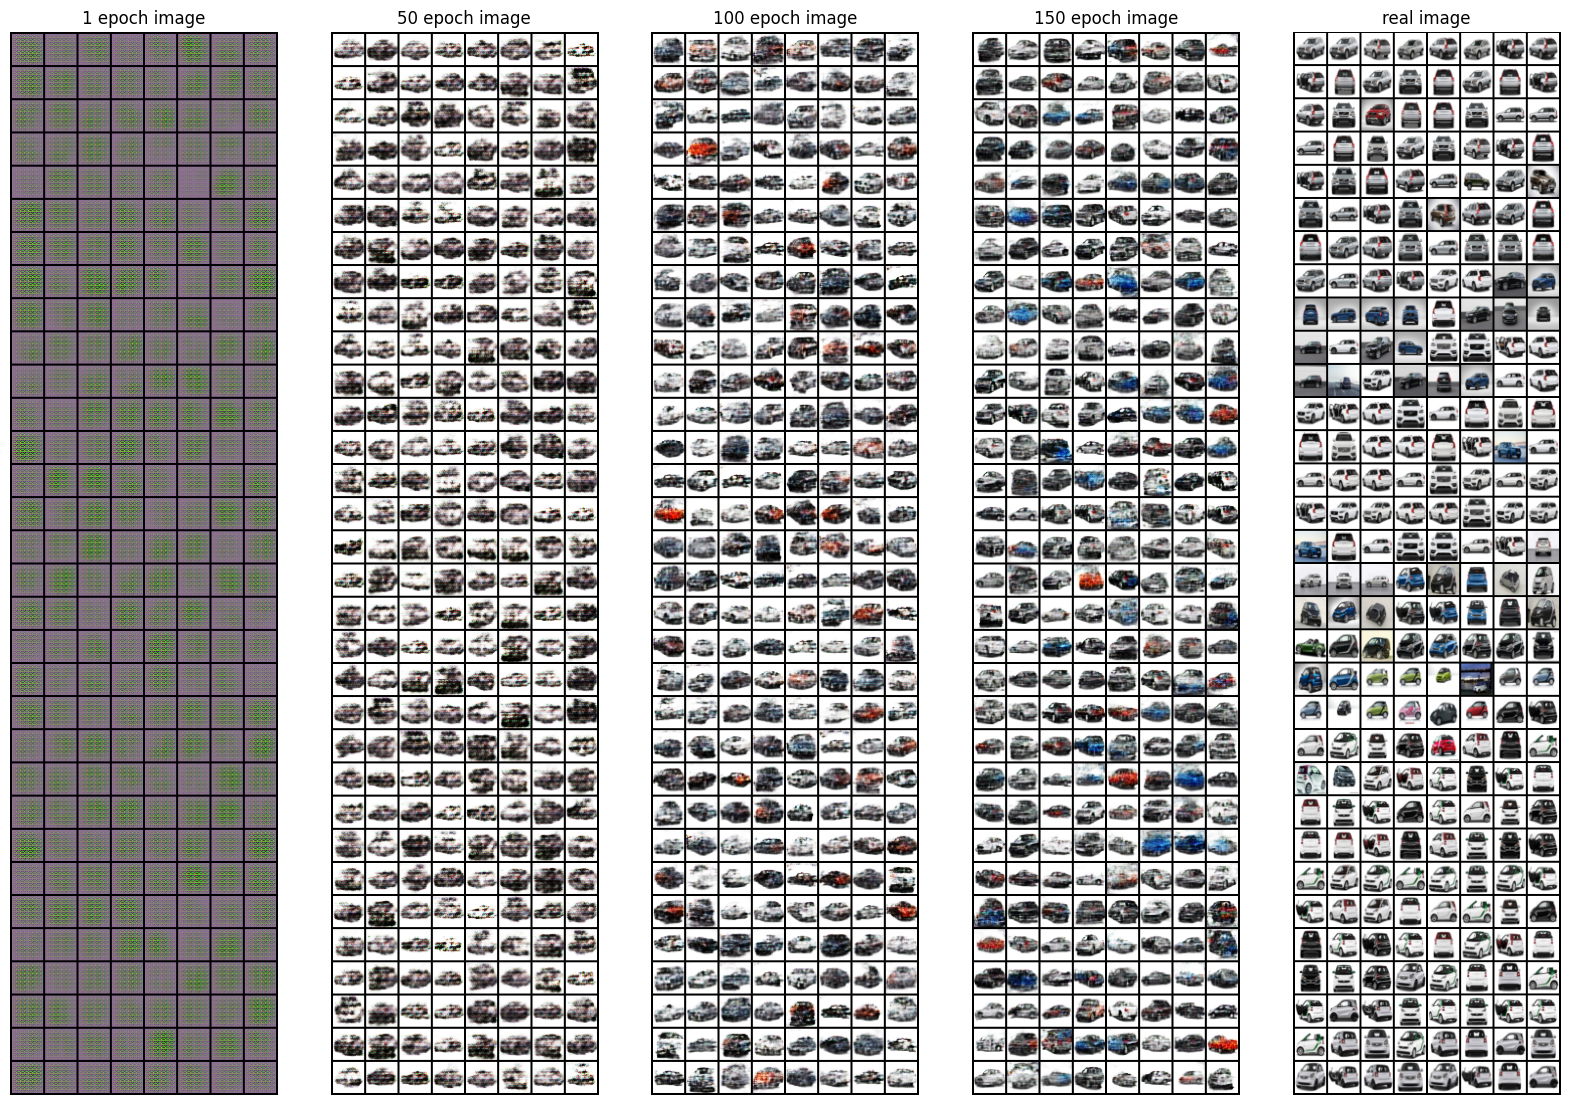

In [31]:
real_path = '/content/drive/MyDrive/Colab_Notebooks/4-1_DL/result/VGAN_IS_car/real_images.png'
fake_path_1 = '/content/drive/MyDrive/Colab_Notebooks/4-1_DL/result/VGAN_IS_car/fake_images-1.png'
fake_path_50 = '/content/drive/MyDrive/Colab_Notebooks/4-1_DL/result/VGAN_IS_car/fake_images-50.png'
fake_path_100 = '/content/drive/MyDrive/Colab_Notebooks/4-1_DL/result/VGAN_IS_car/fake_images-100.png'
fake_path_150 ='/content/drive/MyDrive/Colab_Notebooks/4-1_DL/result/VGAN_IS_car/fake_images-150.png'

plt.figure(figsize=(20,30))
plt.subplot(155)
plt.imshow(view_image(path))
plt.title("real image")
plt.axis("off")

plt.subplot(151)
plt.imshow(view_image(fake_path_1))
plt.title("1 epoch image")
plt.axis("off")

plt.subplot(152)
plt.imshow(view_image(fake_path_50))
plt.title("50 epoch image")
plt.axis("off")

plt.subplot(153)
plt.imshow(view_image(fake_path_100))
plt.title("100 epoch image")
plt.axis("off")

plt.subplot(154)
plt.imshow(view_image(fake_path_150))
plt.title("150 epoch image")
plt.axis("off")

plt.show()